## Importing Data



In [0]:
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#I am using google colab, this code is getting authentication to download from my google drive.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

“I
confirm that this is my own work, except where clearly indicated.”


In [0]:
downloaded = drive.CreateFile({'id':'1tPUnUdqzmtoLJrKMMLECFcCl10ED55AG'})
downloaded.GetContentFile('train.csv')
downloaded2 = drive.CreateFile({'id':'1UnV1Jiep3Yc9Lb7DBsGuMO_dooI8hbDR'})
downloaded2.GetContentFile('test.csv')

In [0]:
testSet=pd.read_csv('test.csv')
trainSet =pd.read_csv('train.csv')

## Exploring & Cleaning Data

In [0]:
trainSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

We have no missing values, this is expected as we are told that any values that were missing have been replaced with '-1'. We have alot of features.

In [0]:
trainSet.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


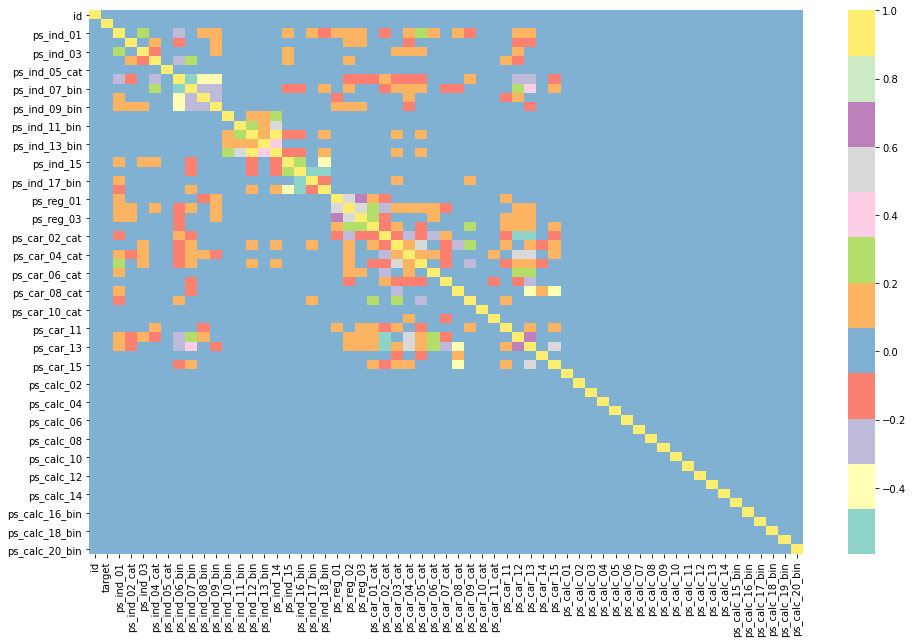

In [0]:
#plotting a correlation map to get an idea of the most important features
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mssno
cor = trainSet.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor,cmap='Set3')

As we can see from the correlation matrix, all of the 'calc' features have very low correlation. I will remove these from the data set.

In [0]:
trainSet=trainSet.drop(trainSet.columns[trainSet.columns.str.startswith('ps_calc')],axis=1)
#do the same for the test set 
testSet=testSet.drop(testSet.columns[testSet.columns.str.startswith('ps_calc')],axis=1)

In [0]:
trainSet.shape

(595212, 39)

Number of columns has decreased from 58 to 39, this should make the data easier to run models on. 
Ill plot the correlation map again.

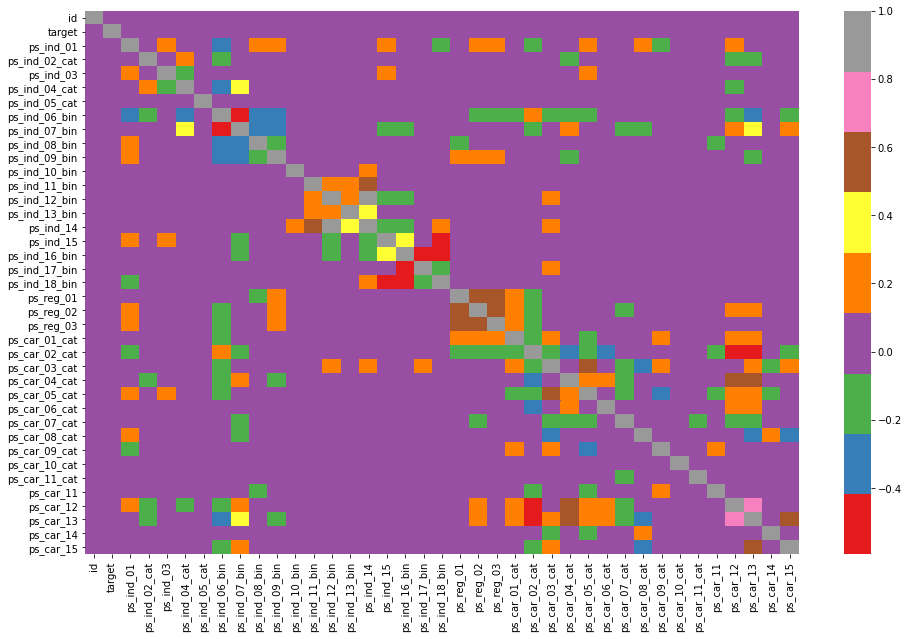

In [0]:
cor = trainSet.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor,cmap='Set1')

Some categories clearly have lower correlations than others, but theres no obvious ones to remove so for now I will leave it.

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

In [0]:
trainSet.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.551102,8.295933,0.829931,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674,2.346072,0.379945,0.813265,0.276256,3.065899
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.793506,2.508270,0.375716,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455,0.832548,0.058327,0.224588,0.357154,0.731366
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.333167,2.828427
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.720677,7.000000,1.000000,-1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,2.000000,1.000000,65.000000,3.000000,0.374166,0.765811,0.368782,3.316625
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.900000,0.600000,1.000000,11.000000,1.000000,0.000000,0.000000,1.000000,11.000000,1.000000,1.000000,2.000000,1.000000,93.000000,3.000000,0.400000,0.906190,0.396485,3.605551
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,13.000000,1.000000,1.000000,1.000000,0.900000,1.800000,4.037945,11.000000,1.000000,1.000000,9.000000,1.000000,17.000000,1.000000,1.000000,4.000000,2.000000,104.000000,3.000000,1.264911,3.720626,0.636396,3.741657


We can see the mean of the target column is 0.036, meaning only 3.6% of entries are '1'. This means when training the model, it will probably just predict everything to be '0' and that alone will allow it to achieve a 96.4% accuracy!

We could undersample the cases with target=0 or over sample the cases with target =1.

I decided to undersample the target=0 cases. On previous attempts to model this data, not performing any undersampling made models just predict every case to be =0 as mentioned above.

In [0]:
 
##the following code implements a method to undersample the 
##cases where the target=0 so that 10% of the training data had target=1.


index_0 = trainSet[trainSet.target == 0].index
index_1 = trainSet[trainSet.target == 1].index

# Get original number of records per target value
target0 = len(trainSet.loc[index_0])
target1 = len(trainSet.loc[index_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-0.1)*target1)/(target0*0.1)
undersampled = int(undersampling_rate*target0)


# Records are randomly selected
undersamp = shuffle(index_0, random_state=37, n_samples=undersampled)


idx_list = list(undersamp) + list(index_1)

# Dataframe where the target=0 cases are now undersampled
trainSet = trainSet.loc[idx_list].reset_index(drop=True)

In [0]:
trainSet['target'].value_counts()

0    195246
1     21694
Name: target, dtype: int64

Will now see what features have missing values, (-1 Values) and need to be imputed somehow.

In [0]:
missingv = []

for f in trainSet.columns:
    missings = trainSet[trainSet[f] == -1][f].count()
    if missings > 0:
        missingv.append(f)
        missings_perc = missings/trainSet.shape[0]
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values


ps_car_03_cat and ps_car_05_cat will be removed as they are missing many data points.




ps_reg_03 replace with mean as it has continuous values

ps_car_11 is ordinal, so will impute with the mode

ps_car_12 replace with mean as it is has continuous values
ps_car_14 replace with mean

the rest are categories, and the -1 column can stay as a category as customers with a missing data set may have some correlation to insurance claims.

In [0]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
trainSet.drop(vars_to_drop, inplace=True, axis=1)


In [0]:
trainSet.shape

(216940, 37)

In [0]:
from sklearn.impute import SimpleImputer

In [0]:
#imputes the parameters as outlined aboved
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
trainSet['ps_reg_03'] = mean_imp.fit_transform(trainSet[['ps_reg_03']]).ravel()
trainSet['ps_car_12'] = mean_imp.fit_transform(trainSet[['ps_car_12']]).ravel()
trainSet['ps_car_14'] = mean_imp.fit_transform(trainSet[['ps_car_14']]).ravel()
trainSet['ps_car_11'] = mode_imp.fit_transform(trainSet[['ps_car_11']]).ravel()


In [0]:
import matplotlib.pyplot as plt
trainSet[1:10].hist(bins=100)
plt.show()


In [0]:
cats = []
for f in trainSet.columns:
  if 'cat' in f:
    cats.append(f)

In [0]:
cats

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_04_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [0]:
trainSet=pd.get_dummies(data=trainSet, columns=['ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat','ps_car_02_cat','ps_car_04_cat','ps_car_06_cat','ps_car_07_cat','ps_car_08_cat','ps_car_09_cat','ps_car_10_cat','ps_car_11_cat'],drop_first=True)

In [0]:
trainSet.shape

(216940, 191)

We now have alot of variables since we got dummies values for the categories.

## Going to start modelling now.

In [0]:
X=trainSet.drop('target',axis=1)
y=trainSet['target']


The data has alot of numbers in similar scales, as if the data has already been standardised but I will run a standard scaler as some models work better with standardised values

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(X)

array([[-0.90494248, -0.45941104, -1.26665356, ..., -0.05814626,
        -0.20392068, -0.41292103],
       [ 0.24006954,  1.55538958,  0.95034274, ..., -0.05814626,
        -0.20392068,  2.42177056],
       [ 1.64508122,  1.05168943, -0.52765479, ..., -0.05814626,
        -0.20392068, -0.41292103],
       ...,
       [ 1.73477713, -0.9631112 ,  0.58084336, ..., -0.05814626,
        -0.20392068,  2.42177056],
       [ 1.73485162, -0.9631112 , -0.89715418, ..., -0.05814626,
        -0.20392068,  2.42177056],
       [ 1.73512631, -0.45941104, -1.26665356, ..., -0.05814626,
        -0.20392068, -0.41292103]])

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

First going to try logistic regression.

In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = logreg.predict(X_test)

In [0]:
ans=pd.DataFrame(y_pred)

In [0]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

In [0]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.08%


In [0]:
print(confusion_matrix(y_test, y_pred))

[[39082     0]
 [ 4306     0]]


We can see our model clearly just predicts every target will have a value of 0. 

Although the kaggle competition wants you to submit the probability each driver will file a claim, not a binary classification. I will run this first very simple model on the test set to get a score from kaggle

# Cleaning the test set.

In [0]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
testSet.drop(vars_to_drop, inplace=True, axis=1)


In [0]:
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
testSet['ps_reg_03'] = mean_imp.fit_transform(testSet[['ps_reg_03']]).ravel()
testSet['ps_car_12'] = mean_imp.fit_transform(testSet[['ps_car_12']]).ravel()
testSet['ps_car_14'] = mean_imp.fit_transform(testSet[['ps_car_14']]).ravel()
testSet['ps_car_11'] = mode_imp.fit_transform(testSet[['ps_car_11']]).ravel()

In [0]:
testSet=pd.get_dummies(data=testSet, columns=['ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat','ps_car_02_cat','ps_car_04_cat','ps_car_06_cat','ps_car_07_cat','ps_car_08_cat','ps_car_09_cat','ps_car_10_cat','ps_car_11_cat'],drop_first=True)

In [0]:
scaler = StandardScaler()
scaler.fit_transform(testSet)

array([[-1.73186728, -0.9576486 ,  1.32817405, ..., -0.0583454 ,
        -0.20733994, -0.40892182],
       [-1.73186496,  1.05594129,  0.2171238 , ..., -0.0583454 ,
         4.82299744, -0.40892182],
       [-1.73186263,  1.55933876, -0.52357636, ..., -0.0583454 ,
        -0.20733994, -0.40892182],
       ...,
       [ 1.73120884, -0.9576486 ,  0.2171238 , ..., -0.0583454 ,
        -0.20733994, -0.40892182],
       [ 1.73121117,  2.06273623,  0.2171238 , ..., -0.0583454 ,
        -0.20733994, -0.40892182],
       [ 1.73121349,  2.5661337 , -0.15322628, ..., -0.0583454 ,
        -0.20733994, -0.40892182]])

In [0]:
testSet.describe()

,id,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_0,ps_ind_04_cat_1,ps_ind_05_cat_0,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_5,ps_ind_05_cat_6,ps_car_01_cat_0,ps_car_01_cat_1,ps_car_01_cat_2,...,ps_car_11_cat_65,ps_car_11_cat_66,ps_car_11_cat_67,ps_car_11_cat_68,ps_car_11_cat_69,ps_car_11_cat_70,ps_car_11_cat_71,ps_car_11_cat_72,ps_car_11_cat_73,ps_car_11_cat_74,ps_car_11_cat_75,ps_car_11_cat_76,ps_car_11_cat_77,ps_car_11_cat_78,ps_car_11_cat_79,ps_car_11_cat_80,ps_car_11_cat_81,ps_car_11_cat_82,ps_car_11_cat_83,ps_car_11_cat_84,ps_car_11_cat_85,ps_car_11_cat_86,ps_car_11_cat_87,ps_car_11_cat_88,ps_car_11_cat_89,ps_car_11_cat_90,ps_car_11_cat_91,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
count,8.928160e+05,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,...,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.00000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,7.441535e+05,1.902371,4.413734,0.393246,0.257191,0.163659,0.185905,0.000373,0.001595,0.009376,0.001039,0.012383,7.296862,0.660591,0.120399,0.154973,0.611057,0.439868,0.894895,2.346610,0.379957,0.813637,0.374672,3.068325,0.725198,0.208524,0.047026,0.018908,0.582314,0.417524,0.886412,0.013905,0.007306,0.014024,0.030647,0.002987,0.034962,0.010013,0.002254,0.003470,...,0.018923,0.005352,0.012035,0.013827,0.003100,0.012822,0.004005,0.004859,0.003087,0.007978,0.002985,0.004410,0.004186,0.012313,0.003484,0.009345,0.002436,0.017575,0.015676,0.008269,0.010668,0.006231,0.028859,0.007493,0.008624,0.00867,0.003041,0.011019,0.004804,0.005615,0.006064,0.003408,0.002473,0.004780,0.020453,0.007566,0.012407,0.003393,0.041218,0.143261
std,4.296830e+05,1.986503,2.700149,0.488471,0.437086,0.369966,0.389030,0.019309,0.039905,0.096375,0.032223,0.127251,3.541948,0.473509,0.325428,0.361879,0.287699,0.404678,0.313025,0.831659,0.058385,0.224779,0.043967,0.729005,0.446415,0.406254,0.211696,0.136199,0.493178,0.493151,0.317310,0.117099,0.085163,0.117590,0.172359,0.054573,0.183685,0.099564,0.047418,0.058804,...,0.136254,0.072959,0.109042,0.116773,0.055594,0.112508,0.063161,0.069535,0.055474,0.088963,0.054553,0.066259,0.064561,0.110278,0.058927,0.096215,0.049297,0.131400,0.124220,0.090559,0.102736,0.078689,0.167411,0.086238,0.092466,0.09271,0.055061,0.104392,0.069144,0.074721,0.077635,0.058281,0.049669,0.068975,0.141545,0.086653,0.110693,0.058147,0.198794,0.350339
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061237,0.00000

In [0]:
#By running the fit with predict_proba, we will output the probability that each 
#driver will produce a crash.
y_preds = logreg.predict_proba(testSet)

In [0]:
ans=pd.DataFrame(y_preds)

In [0]:
ans.head()
#the first column is the probability of the result being =0.
#the second column is the probability of the result being =1.

,0,1
0,0.500000,0.500000
1,0.500001,0.499999
2,0.500001,0.499999
3,0.500002,0.499998
4,0.500003,0.499997


In [0]:
#code to save the data in the correct format for submission
submit5=pd.DataFrame({'id':testSet['id'],'target':ans[1]})
submit5.to_csv('submit5.csv', index=False)

We see from ans.head that the values are very close to 50/50, and as a result this model actually got a negative score on kaggle. This means the model is actually WORSE than just randomly guessing!



# XGBoost Model

In [0]:
from xgboost import XGBClassifier

First simply training the data on the split train and testing sets, then .predict to see the accuracy.

In [0]:
XGBC=XGBClassifier()
XGBC.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
XGBCpred=XGBC.predict(X_test)

In [0]:
accuracy = accuracy_score(y_test, XGBCpred)


In [0]:
XGans=pd.DataFrame(XGBCpred)

In [0]:
XGans[0].value_counts()

0    43387
1        1
Name: 0, dtype: int64

In [0]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.08%


This gives nearly the exact same accuracy as before, it predicts all but one driver to not file a claim.
We will have to run the model in kaggle to see if the actual probabilities it predicts are better.

Instead of splitting the train set into its own training and test set (or validation set) Im actually going to use a cross validation to check the score of the model more accurately

In [0]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [0]:
scores4=cross_val_score(XGBC,X,y,cv=3)


In [0]:
print(scores4)

[0.89985342 0.89992118 0.899935  ]


Now I will run this model on the test set, and submit it to kaggle for testing.

In [0]:
#once again, _proba changes the output to an probability instead of a binary output
XGBCrpred=XGBC.predict_proba(testSet)

In [0]:
ans3=pd.DataFrame(XGBCrpred)

In [0]:
submit10=pd.DataFrame({'id':testSet['id'],'target':ans3[1]})
submit10.to_csv('submit10.csv', index=False)

This Model produced a significantly higher score on kaggle, meaning its calculated probabilites must have been much better.
Score=0.26851

## Tuning HyperParameters

I've chosen to go with the XGBoost model as it has produced the highest score by far. The classifier has a long list of hyperparameters and I will try to tune some of them.

In [0]:
XGBC

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
#first i build a parameter grid, which the model will randomly search through to choose the best parameters.


In [0]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
#this list could be expanded to incldue more params but the runtime is already very long when running the random search

In [0]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [0]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [0]:




random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=5, scoring='roc_auc', n_jobs=4, cv=5, verbose=3, random_state=1 )

# 
 # timing starts from this point for "start_time" variable


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 137.1min finished


This took roughly just over 2 Hours to run

In [0]:

print(random_search.best_params_)

#this cell has no output. On running this file again, on running the randomized search,
#I disconnected from google collaboratory after running for 2hrs. The output of this cell is the-
#- just the values of the hyperparameters used in the 'tunedxgb' model below.

Im now defining my new tuned model as the one recommended by the random grid search. 
I will test its accuracy on the test set and also upload it to kaggle, which will hopefully improve the score

In [0]:
tunedxgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.8, verbosity=1)

In [0]:
tunedxgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.8, verbosity=1)

In [0]:
predictss=tunedxgb.predict(X)

In [0]:
print(confusion_matrix(y, predictss))

[[195237      9]
 [ 21653     41]]


In [0]:
#the model finally predicts some true negatives, instead of saying every customer wont submit a claim

In [0]:
#Running model on the test set

In [0]:
XGBCtuned=tunedxgb.predict_proba(testSet)

In [0]:
ans5=pd.DataFrame(XGBCtuned)

In [0]:
submit15=pd.DataFrame({'id':testSet['id'],'target':ans5[1]})
submit15.to_csv('submit15.csv', index=False)

The model, with the hyperparameters tuned saw the score rise again, from 0.26851 to 0.27791.

Scores on the kaggle sight can be seen on the attached pdf file.

In [0]:
from xgboost import plot_tree

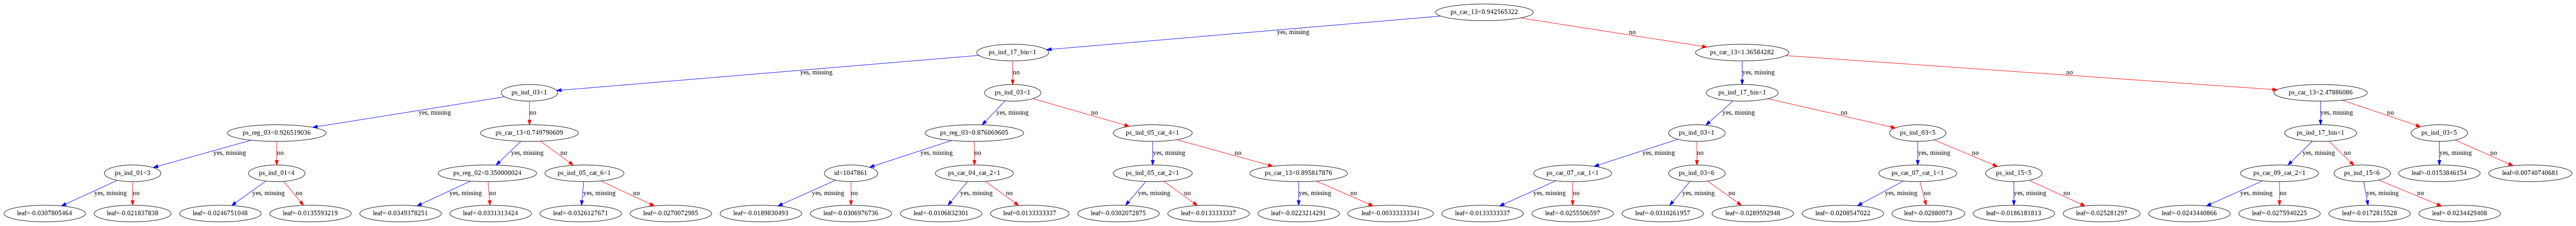

In [0]:
plot_tree(tunedxgb)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree2.png')